# Imports

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from tslearn.clustering import TimeSeriesKMeans



import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [25]:
with open("options.txt", 'r') as f:
    options = f.readlines()
    options = {option.split("=")[0]: option.split("=")[1].strip() for option in options}
print(options)

{'hanoi_scenario_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\Hanoi_CMH\\Scenario-1', 'RUG_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\RUG_data_5years', 'RUG_raw_csv': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_csv.csv', 'RUG_timeseries': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_timeseries.pkl', 'RUG_obfuscated': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data.pkl', 'RUG_no_outliers': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data_rm_outlier.pkl'}


In [26]:
RUG = pd.read_pickle(options['RUG_no_outliers'])

# Preparing and Transforming Data

In [27]:
RUG.interpolate(method='linear', inplace=True, limit=20)

In [28]:
def create_groups(data):
    data_copy = data.copy()
    groups = data_copy.groupby(pd.Grouper(freq='D'))

    # get the calender date of the groups
    days = list(groups.first().index.strftime('%Y:%m:%d'))

    gro = [groups.get_group(x).reset_index(drop=True) for x in groups.groups]

    temp = pd.concat(gro, axis=1, keys=days)

    temp.index = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')

    # drop all columns of temp dataframe which contain nan values
    temp.dropna(axis=1, how='any', inplace=True)

    return temp[::10]

In [29]:
def scale_data(data):
    data_copy = data.copy()
    train_percentage = 0.8
    train_size = int(len(data_copy.columns) * train_percentage)

    train = data_copy.iloc[:, :train_size]
    test = data_copy.iloc[:, train_size:]

    scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_list_train = [train[col] for col in train]
    scaled_list_train = scaler.fit_transform(scaled_list_train)
    
    scaled_list_test = [test[col] for col in test]
    scaled_list_test = scaler.transform(scaled_list_test)

    return scaled_list_train, scaled_list_test

In [30]:
def create_pca(data):
    data_copy = data.copy()
    
    pca = PCA(n_components=0.85, svd_solver='full')
    
    # Fit and transform data
    pca_features = pca.fit_transform(data_copy)

    return pca_features

In [31]:
def create_kmeans(pca_data, scaled_train, scaled_test, clusters=4):
    temp_pca_data = pca_data.copy()
    temp_scaled_train = scaled_train.copy()
    temp_scaled_test = scaled_test.copy()

    kmeans_pca = TimeSeriesKMeans(n_clusters=clusters, metric="dtw",  n_jobs=-1).fit(temp_pca_data)
    train_pca_features = kmeans_pca.labels_
    test_pca_features = kmeans_pca.predict(temp_scaled_test)

    return train_pca_features, test_pca_features

In [44]:
def plot_scores(scaled_list_train, train_lab, test_lab, column):
    fig, ax = plt.subplots((len(set(train_lab))))
    fig.suptitle(column)
    for pos, label in enumerate(set(train_lab)):
        values = scaled_list_train[(train_lab== label).nonzero()[0]]
        for value in values:
            ax[pos].plot(value,c="gray",alpha=0.4)
        ax[pos].plot(np.average(values,axis=0),c="red")


    for i, ax in enumerate(ax.ravel()): # 2
        ax.set_title("Cluster {}".format(i)) # 3

    fig.tight_layout()  
    plt.show()
    return

In [45]:
def average_cluster(column, n_cluster):
    grouped_data = create_groups(RUG[column])

    scaled_list_train, scaled_list_test = scale_data(grouped_data)

    pca_features = create_pca(scaled_list_train)

  
    train_lab, test_lab = create_kmeans(pca_features, scaled_list_train, scaled_list_test, n_cluster)

    plot_scores(scaled_list_train, train_lab, test_lab, column)
    # plot_scores(column, wcss, silhouette_scores, n_cluster)
    return 

In [46]:
clusters = [4, 4, 3, 3, 4, 4, 4, 3, 3, 4, 3, 4, 4]

Location 1 - flow


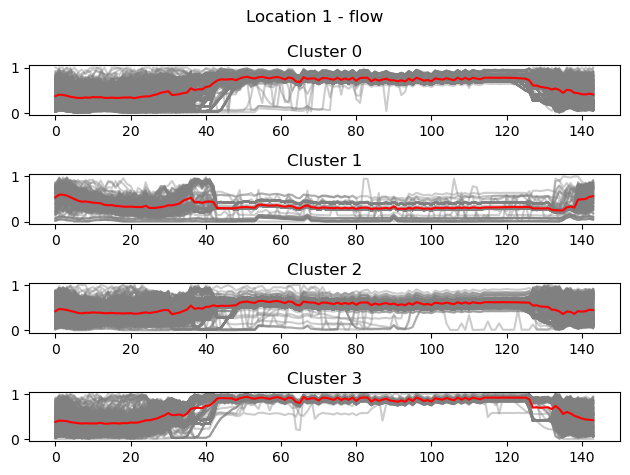

Location 2 - consumption


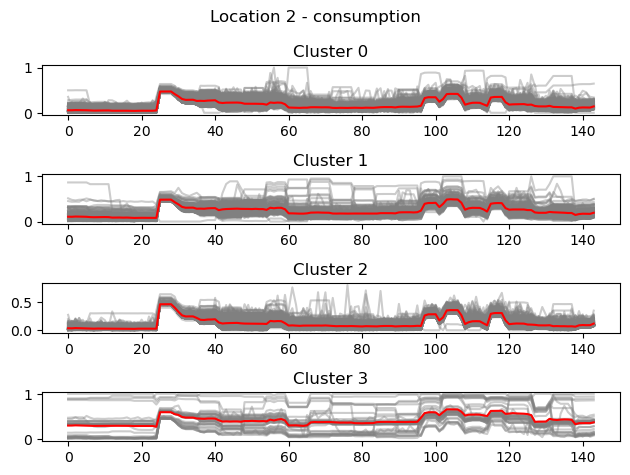

Location 3 - consumption


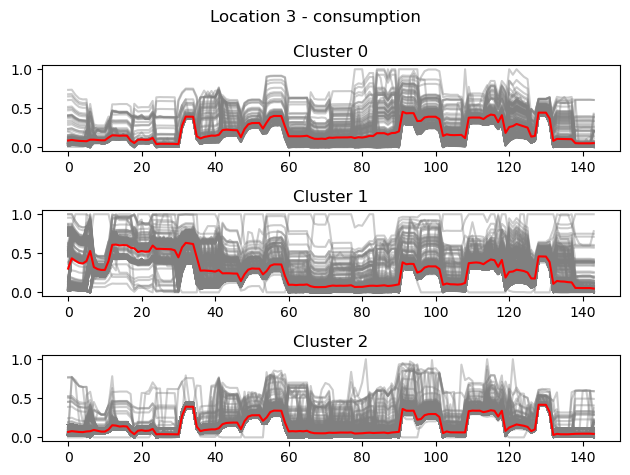

Location 4 - consumption


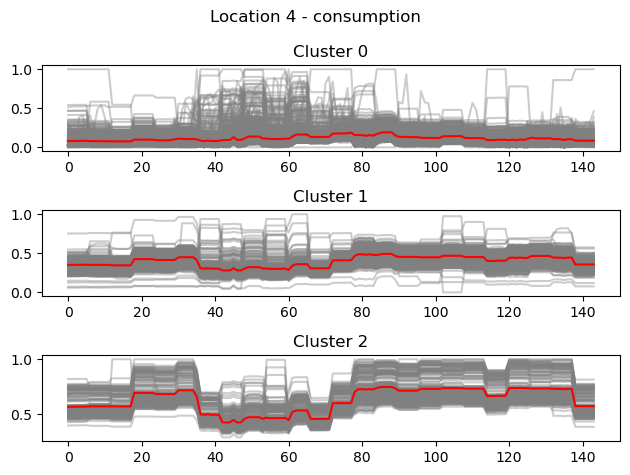

Location 5 - consumption


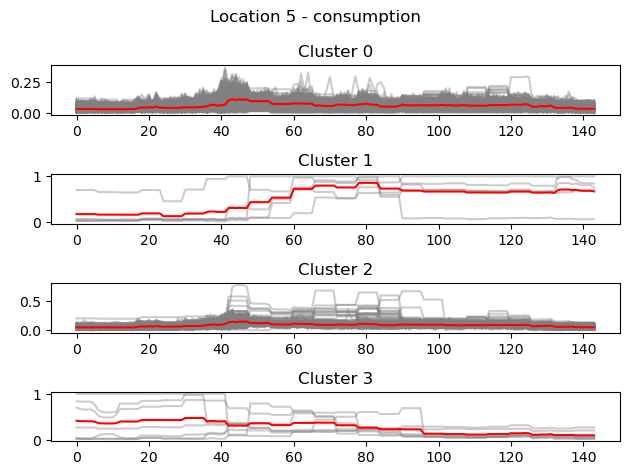

Location 6 - head


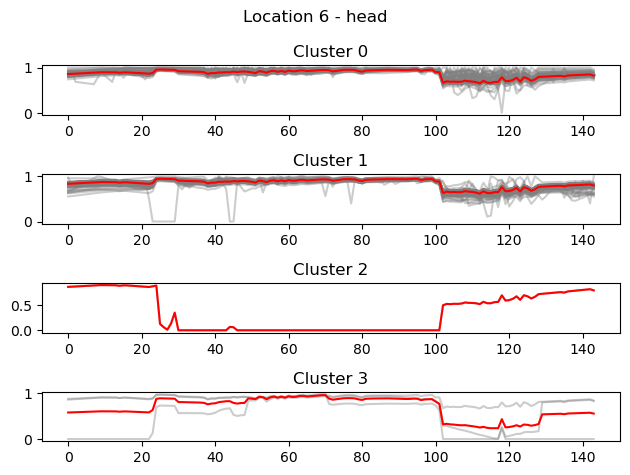

Location 7 - head


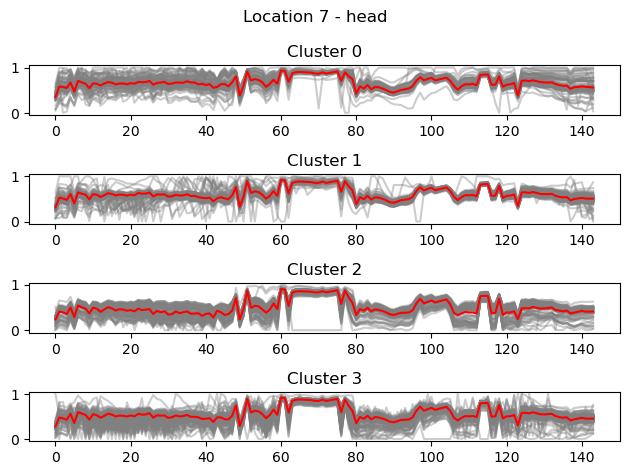

Location 8 - flow


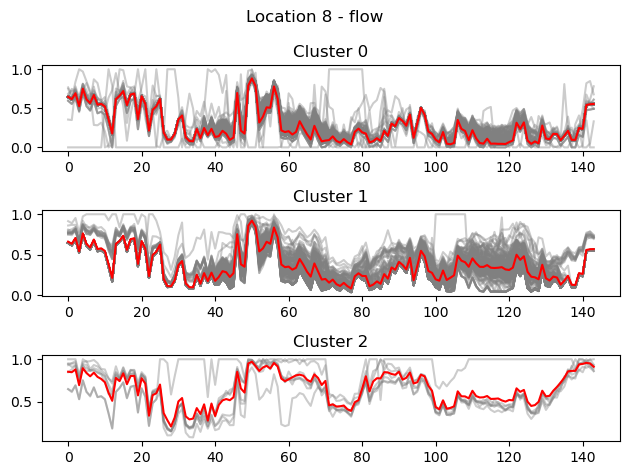

Location 9 - head


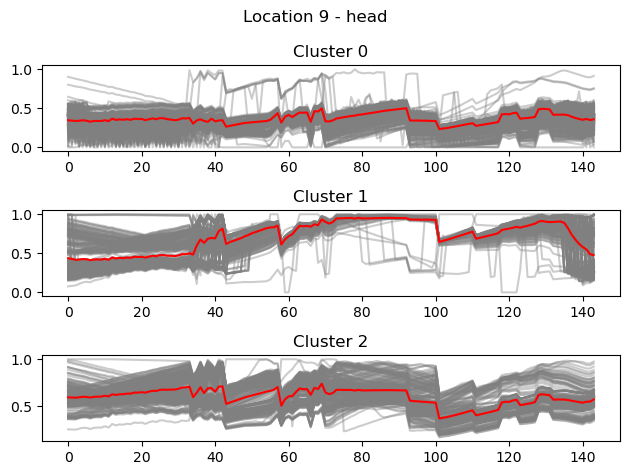

Location 10 - flow


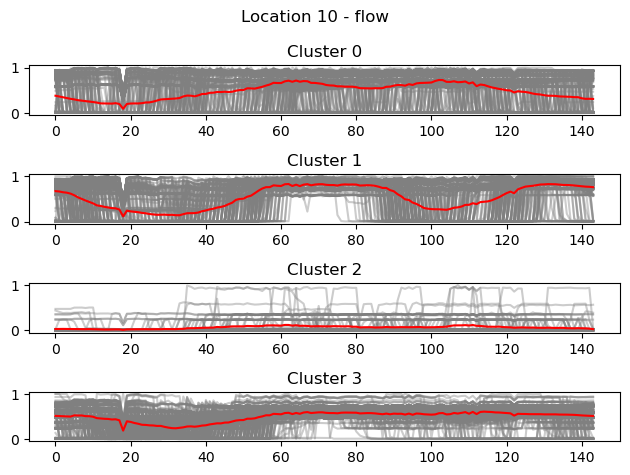

Location 11 - head


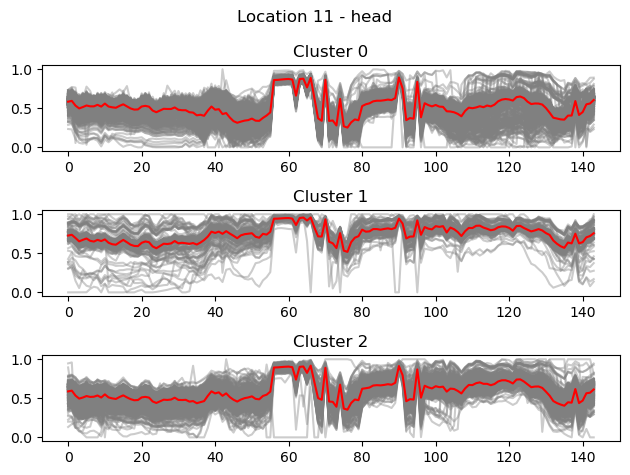

Location 11 - flow


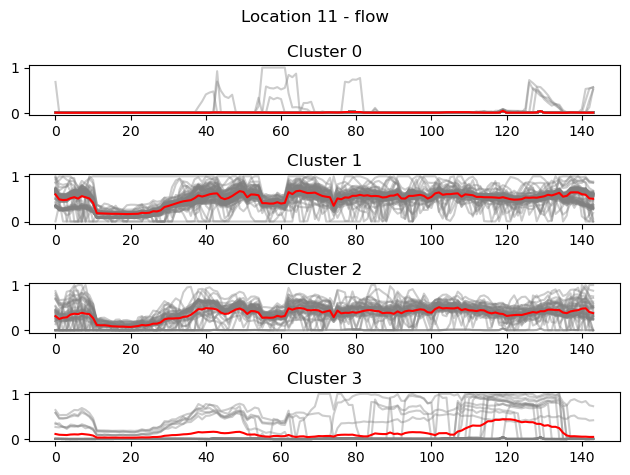

Location 12 - head


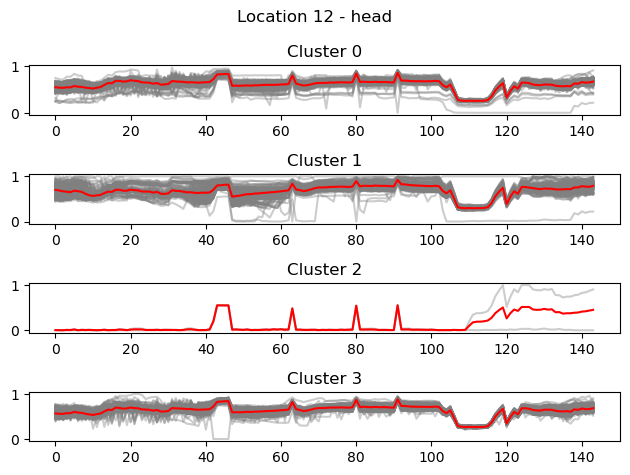

In [47]:
for column, n_cluster in zip(RUG.columns, clusters):
    print(column)
    average_cluster(column, n_cluster)
    